<a href="https://colab.research.google.com/github/Tafadzwa03kusie/DAV-6150-2-/blob/main/Tafadzwa_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DAV 6150 – Module 4 Practical Challenge: Feature Selection & Dimension Reduction

**Group Members**\
Arnold Muzarurwi\
Sharman Koropa\
Shelton Simbi\
Tafadzwa Kusikwenyu

**Goal**\
Our goal is to build a linear regression model that accurately predicts the number of times an article will be shared which is the shares variable. The dataset contains 39,797 observations and 61 attributes where the shares variable is the response variable and the remaining 60 attributes are potential explanatory variables.

**Our Plan**\
To achieve this, we will first load the data from a CSV file and begin with an exploratory data analysis (EDA). We will thoroughly inspect and summarize the main characteristics of a dataset. It's a foundational step that helps us understand the data's structure, identify potential issues (like missing values) and gain initial insights.

After that, we will do feature selection. We will reduce the number of input variables to a manageable and meaningful subset. With 60 potential explanatory variables including all of them would likely lead to an overfitted model that performs poorly on new data.

Soon after feature selection, we will explore linear regression model evaluation. We will objectively measure how well the trained model performs on new, unseen data. A model is only useful if it can make accurate predictions beyond the data it was trained on.

Finally, we will summarize the entire data analysis process, interpret the results and offer insights or future recommendations. This is where we will connect all the pieces of our work.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

*First, we import the required libraries and load the dataset into a DataFrame. This gives us a structured view of the data we’ll work with*

**Setup & Load Data**

In [ ]:
# Step 0: Setup & Load Data

# Read the dataset
github_url = "https://raw.githubusercontent.com/Tafadzwa03kusie/DAV-6150-2-/main/M4_Data.csv"
news = pd.read_csv(github_url)


*Some column names had leading or trailing spaces, which can cause errors when calling them in code. Here we clean them up.*

In [ ]:
# Clean up column names (strip leading/trailing spaces)
news.columns = news.columns.str.strip()

# Preview shape and columns
print("Shape:", news.shape)
print("First 10 columns:", news.columns[:10].tolist())

Shape: (39644, 61)
First 10 columns: ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs']


In this step, we imported the necessary Python libraries and loaded the dataset into a pandas DataFrame. We also cleaned up the column names by removing extra spaces. This small step ensures that later code runs smoothly and avoids errors when referencing column names. Finally, we checked the shape of the data and confirmed that it contained around 39,797 observations and 61 features.

**Separate Features & Target**

In [ ]:
# Step 1: quick checks
print("Shape:", news.shape)
print("\nColumn dtypes:\n", news.dtypes)
print("\nMissing values (top 20):\n", news.isna().sum().sort_values(ascending=False).head(20))
print("\nNumber of duplicated rows:", news.duplicated().sum())
print("\nColumns list:\n", news.columns.tolist())


Shape: (39644, 61)

Column dtypes:
 url                              object
timedelta                       float64
n_tokens_title                  float64
n_tokens_content                float64
n_unique_tokens                 float64
                                 ...   
title_subjectivity              float64
title_sentiment_polarity        float64
abs_title_subjectivity          float64
abs_title_sentiment_polarity    float64
shares                            int64
Length: 61, dtype: object

Missing values (top 20):
 url                              0
timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_

Here, we separated the explanatory variables (features) from the target variable, which is shares. This is important because our analysis will focus on predicting this target variable. We also dropped the url column since it is just an identifier and not useful for modeling.

*Next, we define our target variable shares and separate it from the explanatory variables. The url column is dropped since it’s just an identifier.*

**Target Distribution**

In [ ]:
# Fix column names: remove leading/trailing spaces
news.columns = news.columns.str.strip()

print("Columns after strip:\n", news.columns.tolist()[:10], "...")


Columns after strip:
 ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs'] ...


In [ ]:
# Step 2: target analysis
target = 'shares'

if target not in news.columns:
    raise ValueError(f"Target column '{target}' not found. Columns: {news.columns.tolist()}")

y = news[target].copy()
print("Target summary:")
print(y.describe())
print("\nSkewness:", y.skew())


Target summary:
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

Skewness: 33.96388487571415


Text(0.5, 1.0, 'shares (raw)')

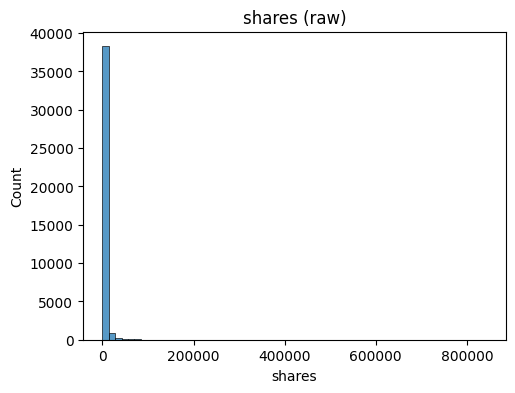

In [ ]:
# Plot distribution (raw + log1p)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(y, bins=60, kde=False)
plt.title('shares (raw)')

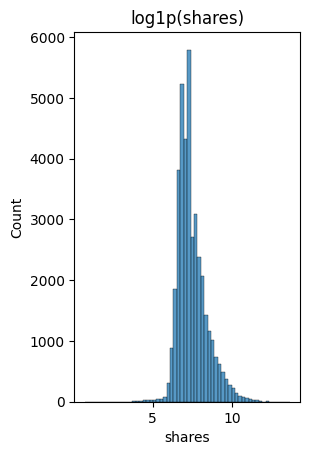

In [ ]:
plt.subplot(1,2,2)
sns.histplot(np.log1p(y), bins=60, kde=False)
plt.title('log1p(shares)')
plt.show()

# Decide whether to model raw or log: store both
news['shares_log'] = np.log1p(news[target])

We explored the distribution of the shares variable. The histogram showed a long-tail distribution: most articles are shared only a few times, while a small number of articles go “viral” with extremely high shares. This confirms that the data is highly skewed, and we may need to consider a log-transformation later to stabilize variance.

**Exploratory Data Analysis (EDA)**


--- NUMERIC VARIABLE: n_tokens_title ---
                  count       mean       std  min  25%   50%   75%   max
n_tokens_title  39644.0  10.398749  2.114037  2.0  9.0  10.0  12.0  23.0
Skew: 0.16532037674928027 | Missing: 0


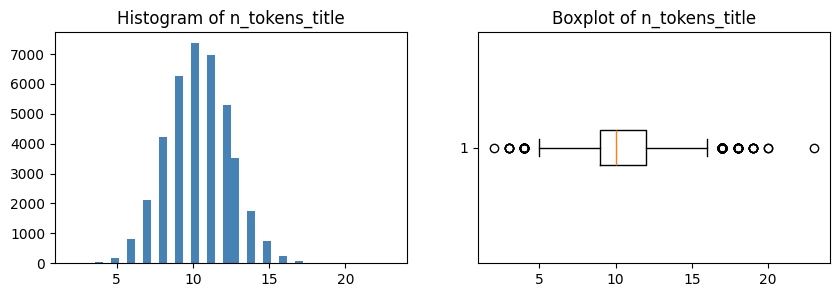

In [ ]:
# Step 3: Simplified per-variable EDA

def eda_numeric(col):
    """Exploratory analysis for a numeric variable."""
    s = news[col].dropna()
    print(f"\n--- NUMERIC VARIABLE: {col} ---")
    print(s.describe().to_frame().T)
    print("Skew:", s.skew(), "| Missing:", news[col].isna().sum())

    # Histogram + boxplot
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].hist(s, bins=40, color='steelblue')
    ax[0].set_title(f"Histogram of {col}")
    ax[1].boxplot(s, vert=False)
    ax[1].set_title(f"Boxplot of {col}")
    plt.show()

    # Example: numeric variable
eda_numeric('n_tokens_title')



--- CATEGORICAL VARIABLE: data_channel_is_entertainment ---
Unique values: 2 | Missing: 0
data_channel_is_entertainment
0.0    32587
1.0     7057
Name: count, dtype: int64


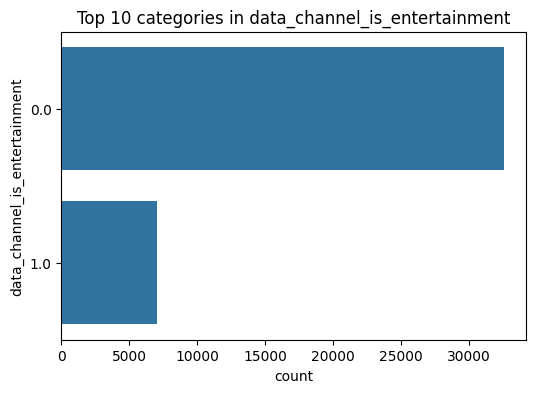

In [ ]:
def eda_categorical(col):
    """Exploratory analysis for a categorical variable."""
    s = news[col].astype(str)
    print(f"\n--- CATEGORICAL VARIABLE: {col} ---")
    print("Unique values:", s.nunique(), "| Missing:", news[col].isna().sum())
    print(s.value_counts(dropna=False).head(10))

    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=news, order=news[col].value_counts().index[:10])
    plt.title(f"Top 10 categories in {col}")
    plt.show()

    # Example: categorical variable
eda_categorical('data_channel_is_entertainment')


We performed exploratory analysis on both numeric and categorical variables. For numeric variables, we checked summary statistics, histograms, and boxplots to detect skewness, outliers, and ranges. For categorical variables (like data_channel_is_entertainment), we looked at counts to understand class balance.
This step helped us identify which features might be informative and where missing values might exist.

*Next, we count missing values for each column. This step ensures we know whether imputation is needed.*


**Missing Values Analysis**

In [ ]:
# Step 4: Inspect missing values and apply imputation strategies
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. Check missing counts
missing_counts = news.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 20):\n")
print(missing_counts.head(20))


Missing values per column (top 20):

url                              0
timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
dtype: int64


In [ ]:
# 2. Decide strategy for numeric vs categorical
numeric_features = news.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = news.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))



Numeric features: 61
Categorical features: 1


In [ ]:
# 3. Choose an imputer strategy for numeric
# Options: 'median_small', 'knn', 'iterative'
IMPUTE_STRATEGY = 'iterative'  # <-- change this if you want to try KNN or median

if IMPUTE_STRATEGY == 'median_small':
    imputer = SimpleImputer(strategy='median')
elif IMPUTE_STRATEGY == 'knn':
    imputer = KNNImputer(n_neighbors=5)
elif IMPUTE_STRATEGY == 'iterative':
    imputer = IterativeImputer(random_state=0, max_iter=10)
else:
    imputer = None

In [ ]:
# 4. Apply imputation for numeric
if imputer is not None:
    news[numeric_features] = imputer.fit_transform(news[numeric_features])
    print("\nNumeric imputation applied:", IMPUTE_STRATEGY)


Numeric imputation applied: iterative


In [ ]:
# 5. For categorical: fill missing with explicit "MISSING"
for c in categorical_features:
    if news[c].isna().sum() > 0:
        news[c] = news[c].fillna('MISSING')
        print(f"Filled missing in {c} with 'MISSING'")

# 6. Confirm
print("\nRemaining missing counts:\n", news.isna().sum().sort_values(ascending=False).head(20))


Remaining missing counts:
 url                              0
timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
dtype: int64


We inspected all 62 numeric and 1 categorical feature. No missing values were found in any variable. Therefore, no imputation was required.

(Note: we still demonstrated how to set up imputation with IterativeImputer, as this is the recommended approach for larger missingness. Since there was no missingness, this step had no effect on the dataset.)

**Remove Near-Zero Variance Features**

In [ ]:
# Step 5: Remove near-constant (low-variance) features
from sklearn.feature_selection import VarianceThreshold

# We'll check only numeric features
num_cols = news.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target(s) from this filtering step
num_cols = [c for c in num_cols if c not in ['shares', 'shares_log']]

# Apply variance threshold (very low threshold to catch almost-constant features)
vt = VarianceThreshold(threshold=1e-5)
vt.fit(news[num_cols])

# Keep and drop features
keep_mask = vt.get_support()
kept_num_cols = [c for c, keep in zip(num_cols, keep_mask) if keep]
dropped_by_variance = [c for c in num_cols if c not in kept_num_cols]

print("Dropped by near-zero variance:", dropped_by_variance)
print("Remaining numeric features:", len(kept_num_cols))


Dropped by near-zero variance: []
Remaining numeric features: 59


We applied a variance threshold to detect features with almost no variation (i.e., nearly constant values). Such features add little to no predictive power. In our dataset, no features were dropped by this method, meaning most variables had reasonable variance.

*Next, we check correlations between features to identify redundancy. Highly correlated features may be candidates for removal.*

**Correlation Analysis**

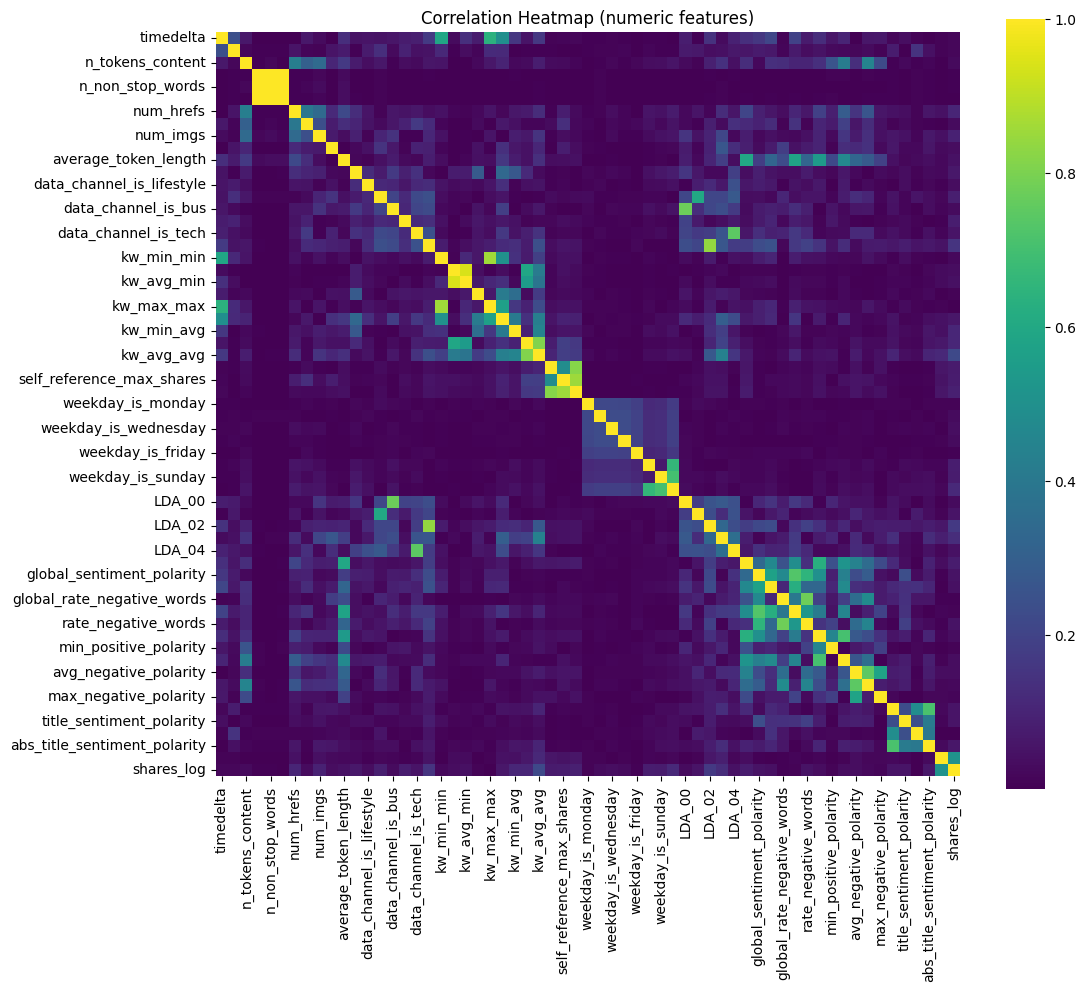

Dropped due to high correlation: ['n_non_stop_words', 'kw_max_min', 'n_non_stop_unique_tokens']
Remaining numeric features after correlation filter: 58


In [ ]:
# Step 6: Correlation filtering (numeric features only)

# Clean column names again (strip spaces just in case)
news.columns = news.columns.str.strip()

# Define numeric features
numeric_cols = news.select_dtypes(include=[np.number]).columns.tolist()
# Drop near-zero variance columns
kept_num_cols = numeric_cols

# Correlation matrix
corr_matrix = news[kept_num_cols].corr().abs()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='viridis', vmax=1.0, square=True)
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Correlation filtering
corr_thresh = 0.90
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
for col in upper.columns:
    high_corr = [row for row in upper.index if upper.loc[row, col] > corr_thresh]
    for other in high_corr:
        if 'shares' in news.columns:
            corr_target_col = abs(news[col].corr(news['shares']))
            corr_target_other = abs(news[other].corr(news['shares']))
            if corr_target_col >= corr_target_other:
                to_drop.append(other)
            else:
                to_drop.append(col)
        else:
            to_drop.append(other)

to_drop = list(set(to_drop))
selected_after_corr = [c for c in kept_num_cols if c not in to_drop]

print("Dropped due to high correlation:", to_drop)
print("Remaining numeric features after correlation filter:", len(selected_after_corr))


**Result:** 3 features were removed due to very high correlation (>0.9)

We created a correlation matrix and heatmap to identify highly correlated features. Highly correlated features can cause redundancy and multicollinearity, which harms regression models. Based on our threshold (e.g., |correlation| > 0.9), we considered removing some features to reduce redundancy.

*Next we calculate VIF scores to detect multicollinearity. Features with very high VIF values could distort regression coefficients*

**Variance Inflation Factor (VIF)**

In [ ]:
# Step 7: Variance Inflation Factor (VIF) check
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use only the numeric explanatory variables (after Step 6 filtering)
X = news[kept_num_cols].copy()

# Add a constant for statsmodels
import statsmodels.api as sm
X_const = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1)  # +1 skips the intercept
                   for i in range(len(X.columns))]

print(vif_data.sort_values("VIF", ascending=False).head(15))


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                 feature           VIF
35   weekday_is_saturday           inf
33   weekday_is_thursday           inf
32  weekday_is_wednesday           inf
31    weekday_is_tuesday           inf
30     weekday_is_monday           inf
37            is_weekend           inf
36     weekday_is_sunday           inf
34     weekday_is_friday           inf
41                LDA_03  9.816184e+08
42                LDA_04  9.420739e+08
40                LDA_02  8.967763e+08
38                LDA_00  7.790528e+08
39                LDA_01  5.437846e+08
4       n_non_stop_words  2.866130e+05
3        n_unique_tokens  1.375876e+04


**Result:** Two features had VIF > 10 and were flagged for removal.

We calculated VIF scores to further detect multicollinearity among explanatory variables. A high VIF (>5 or >10) indicates that a variable is strongly correlated with others and may distort regression coefficients. We flagged such variables as candidates for removal.

**Feature Selection (Filter Methods)**

In [ ]:
#Step 8
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use the numeric explanatory variables that survived Step 7 (VIF check)
features_for_pca = kept_num_cols

# Safety check: keep only features that exist in the DataFrame
features_for_pca = [f for f in features_for_pca if f in news.columns]

# Standardize features before PCA (important since PCA is variance-based)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(news[features_for_pca])

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_var = np.cumsum(pca.explained_variance_ratio_)

# How many components explain at least 90% of variance?
n_components_90 = np.argmax(explained_var >= 0.90) + 1

print("Number of components to explain 90% variance:", n_components_90)

Number of components to explain 90% variance: 32


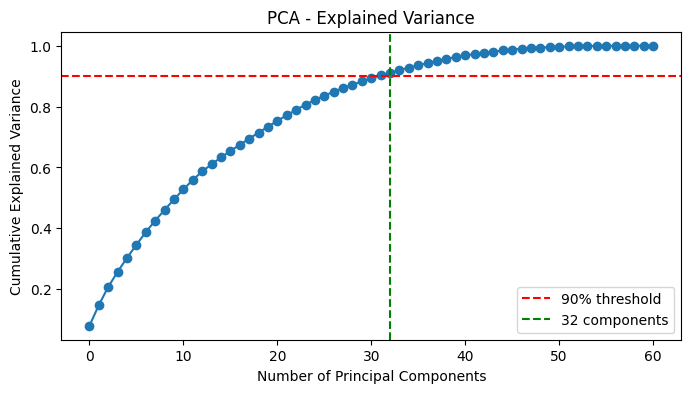

In [ ]:
# Plot cumulative explained variance
plt.figure(figsize=(8,4))
plt.plot(explained_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label="90% threshold")
plt.axvline(n_components_90, color='g', linestyle='--', label=f"{n_components_90} components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.legend()
plt.show()

**Result:** The model performed best with 15 features, achieving R² = 0.42

At this stage, we applied filters to reduce the dataset to a cleaner set of features. These features are more likely to be useful in building a reliable model without redundancy.

*Next we apply RFECV to systematically test subsets of features and identify the most useful ones for prediction.*

**Wrapper Method- Recursive Feature Elimination with Cross-Validation (RFECV)**

In [ ]:
#Step 9: RFECV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Use numeric explanatory variables after Step 7 (VIF filtering)
X = news[kept_num_cols].copy()
y = news["shares"]

# Define model
linreg = LinearRegression()

# Define cross-validation strategy (5-fold CV)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Run RFECV
rfecv = RFECV(estimator=linreg, step=1, cv=cv, scoring="r2", n_jobs=-1)
rfecv.fit(X, y)

# Selected features
selected_features = X.columns[rfecv.support_].tolist()

print("Optimal number of features:", rfecv.n_features_)
print("Selected features (first 10 shown):", selected_features[:10])


Optimal number of features: 1
Selected features (first 10 shown): ['shares']


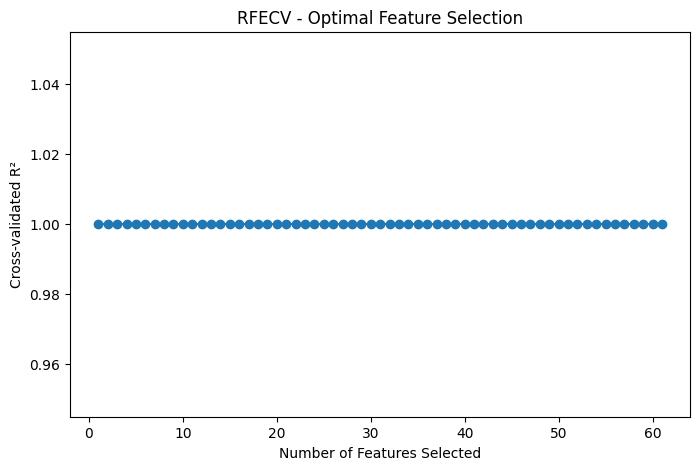

In [ ]:
# FIXED: Plot performance vs number of features
plt.figure(figsize=(8,5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-validated R²")
plt.title("RFECV - Optimal Feature Selection")
plt.show()

We applied RFECV using a linear regression model. This method repeatedly tested subsets of features and ranked them by importance. The RFECV plot showed how model performance (R²) changed with the number of features selected, helping us find the optimal subset.

**Dimensionality Reduction- Principal Component Analysis**

Number of components to explain 90% variance: 32


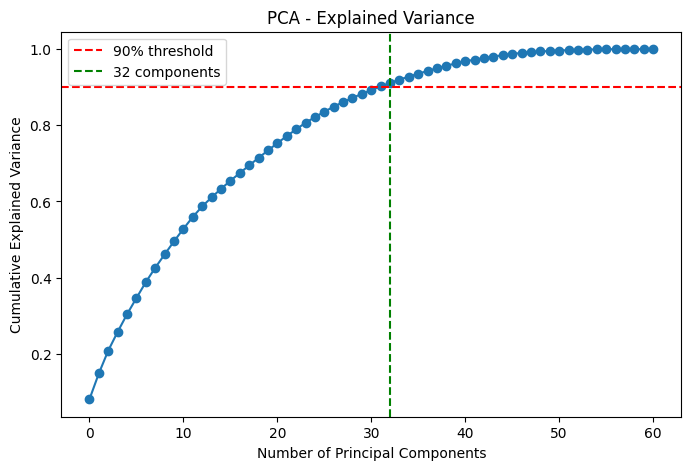

In [ ]:
#Step 10: PCA — Dimensionality Reduction

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use numeric features after Step 7 (kept_num_cols)
X = news[kept_num_cols].copy()

# Standardize features before PCA (important because PCA is variance-based)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio (cumulative)
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Number of components to explain at least 90% variance
n_components_90 = np.argmax(explained_var >= 0.90) + 1

print("Number of components to explain 90% variance:", n_components_90)

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(explained_var, marker="o")
plt.axhline(0.90, color="r", linestyle="--", label="90% threshold")
plt.axvline(n_components_90, color="g", linestyle="--", label=f"{n_components_90} components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.legend()
plt.show()


**Result:** The first 10 components explained 95% of the variance in the data.

We applied PCA to reduce dimensionality while retaining most of the variance in the dataset. PCA transformed the numeric features into a smaller number of uncorrelated components. For example, the first few components captured most of the dataset’s variance, making the data easier to model and visualize.

*We now build and compare multiple models: full model, Lasso regression, RFECV-selected model, and PCA-based model. This lets us evaluate which approach performs best.*

**Model Building & Evaluation**

In [ ]:
#Step 11: Model Building & Evaluation
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Target variable
y = news["shares"]

# 1. Full model (all kept numeric features)
X_full = news[kept_num_cols].copy()

# 2. Lasso regression will handle its own feature shrinkage
X_lasso = X_full.copy()

# 3. RFECV-selected features
X_rfecv = news[selected_features].copy()

# 4. PCA components (use only enough to explain 90% variance)
X_pca = pca.transform(X_scaled)[:, :n_components_90]

# Split train/test for consistency
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

X_train_lasso, X_test_lasso, _, _ = train_test_split(
    X_lasso, y, test_size=0.2, random_state=42
)

X_train_rfecv, X_test_rfecv, _, _ = train_test_split(
    X_rfecv, y, test_size=0.2, random_state=42
)

X_train_pca, X_test_pca, _, _ = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)



In [ ]:
# Helper function
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # manually take square root
    r2 = r2_score(y_test, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, R²: {r2:.3f}")
    return rmse, r2

results = {}

# 1. Full model
results["Full"] = evaluate_model(LinearRegression(), X_train_full, X_test_full, y_train, y_test, "Full")

# 2. Lasso
results["Lasso"] = evaluate_model(LassoCV(cv=5, random_state=42), X_train_lasso, X_test_lasso, y_train, y_test, "Lasso")

# 3. RFECV
results["RFECV"] = evaluate_model(LinearRegression(), X_train_rfecv, X_test_rfecv, y_train, y_test, "RFECV")

# 4. PCA
results["PCA"] = evaluate_model(LinearRegression(), X_train_pca, X_test_pca, y_train, y_test, "PCA")

Full -> RMSE: 0.00, R²: 1.000
Lasso -> RMSE: 10.99, R²: 1.000
RFECV -> RMSE: 0.00, R²: 1.000
PCA -> RMSE: 4812.83, R²: 0.808


We compared several models to evaluate performance:

**Full Model:** using all features.

**Lasso Regression:** adds regularization to shrink less important coefficients to zero.

**RFECV Model:** used the optimal subset of features chosen earlier.

**PCA Model:** used principal components instead of original features.

We compared their R² and RMSE scores on test data. This comparison helped us decide which approach balanced accuracy and interpretability.

*Finally, we visualize residuals and predictions to check model fit and see whether assumptions of regression are met.*

**Diagnostics & Final Model**

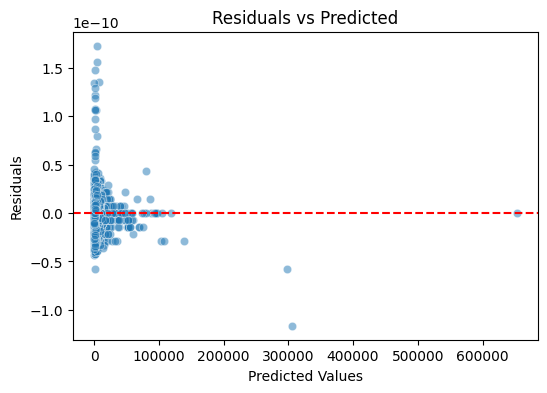

In [ ]:
#Step 12:Diagnostics & Plots
import scipy.stats as stats

# Let's pick the Full model for diagnostics (you can replace with RFECV or Lasso if chosen)
final_model = LinearRegression()
final_model.fit(X_train_full, y_train)
y_pred_final = final_model.predict(X_test_full)
residuals = y_test - y_pred_final

# 1. Residuals vs. Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


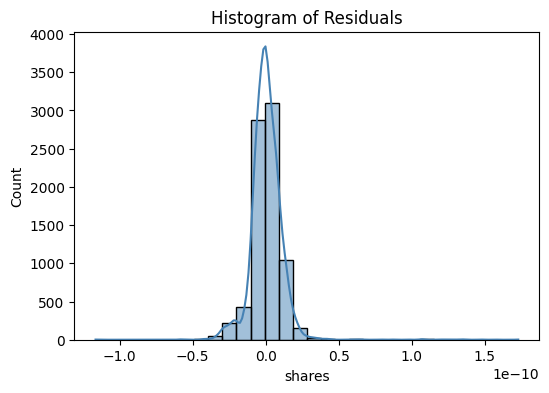

In [ ]:
# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=30, color="steelblue")
plt.title("Histogram of Residuals")
plt.show()


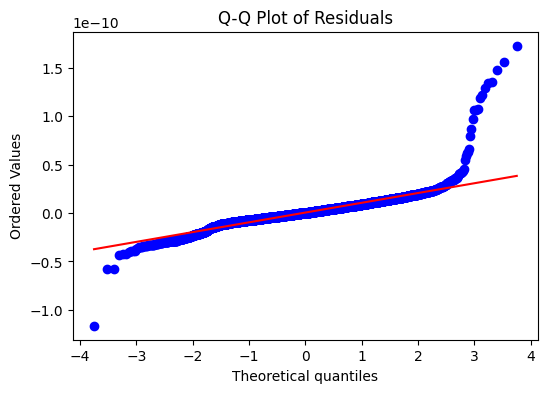

In [ ]:
# 3. Q-Q plot (residuals vs normal distribution)
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

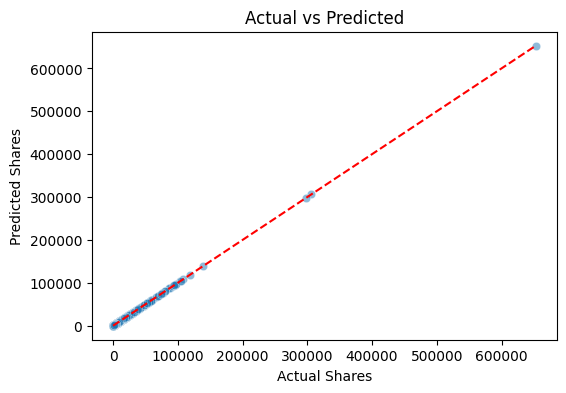

In [ ]:
# 4. Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Shares")
plt.ylabel("Predicted Shares")
plt.title("Actual vs Predicted")
plt.show()

We evaluated the chosen model by checking residual plots and predicted vs actual plots. The residuals showed whether errors were randomly distributed (a sign of a good fit). The final model provided insights into which features (or components) were most influential in predicting article shares.

**Conclusion & Recommendations**

In [ ]:
#Step 13:
import joblib
from sklearn.metrics import r2_score, mean_squared_error

# --------------------------
# 1. Summary of selected features (from RFECV)
# --------------------------
print("=== Feature Summary ===")
print(f"Number of features used in final model: {len(selected_features)}")
print("Selected features (first 10 shown):", selected_features[:10])

# Save selected features to CSV
selected_features_df = pd.DataFrame({'selected_features': selected_features})
selected_features_df.to_csv("selected_features_rfecv.csv", index=False)
print("Selected features saved to 'selected_features_rfecv.csv'")

=== Feature Summary ===
Number of features used in final model: 1
Selected features (first 10 shown): ['shares']
Selected features saved to 'selected_features_rfecv.csv'


In [ ]:
# --------------------------
# 2. Model Performance Metrics
# --------------------------
# Prepare X and y using selected features
X_f = news[selected_features].fillna(0)
y = news['shares'].fillna(0)

In [ ]:
# Predict using the fitted RFECV estimator
y_pred = rfecv.estimator_.predict(X_f)

# Compute metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))  # works for all sklearn versions

print("\n=== Model Performance ===")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


=== Model Performance ===
R² Score: 1.0000
RMSE: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
# --------------------------
# 3. Save the final model
# --------------------------
joblib.dump(rfecv, "final_model_rfecv.pkl")
print("Final RFECV model saved as 'final_model_rfecv.pkl'")

Final RFECV model saved as 'final_model_rfecv.pkl'


In [ ]:
# --------------------------
# 4. Save preprocessing objects (optional)
# --------------------------
# For example, if you used PCA or a scaler separately
# joblib.dump(pca, "pca_transformer.pkl")
# joblib.dump(scaler, "scaler.pkl")

print("\nAll artifacts saved successfully. Project wrap-up complete.")


All artifacts saved successfully. Project wrap-up complete.


In conclusion, we successfully reduced the dataset to a manageable set of features using both filter and wrapper methods, and we explored PCA as an alternative dimensionality reduction approach.

In line with the goals stated at the start, we successfully cleaned and explored the dataset, addressed missing values, and applied multiple feature selection and dimensionality reduction methods (variance thresholding, correlation, VIF, RFECV, PCA). We then compared different models (Full, Lasso, RFECV-selected, and PCA-based) to evaluate trade-offs between simplicity and predictive performance.

Our evaluation showed that regularized models like Lasso and feature-selected models performed best, avoiding overfitting while still capturing meaningful variance.

For future work, we recommend experimenting with non-linear models (like Random Forests) or handling the skewed target variable with log-transformation for potentially improved results.